# Import Dependencies

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, auc, precision_score, recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy as sp
import seaborn as sns
import pickle
import time
from tqdm import tqdm
from wordcloud import WordCloud

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

# Load Dataset

In [82]:
df = pd.read_csv('cleaned_tweets_augmented.csv')
df.head()

,label,cleaned_tweet
0,1,bout play game lol
1,0,shilpa shetty turns year oldergtgtgt bihday oneworldnews
2,0,completely random not believe countrys two presidential nominees racist bigot hypocritical witch
3,0,get lucky saycheese gamber community center
4,0,tragic daughter already inspired thevoice ripchristina covers piano rolemodel


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31887 entries, 0 to 31886
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          31887 non-null  int64 
 1   cleaned_tweet  31886 non-null  object
dtypes: int64(1), object(1)
memory usage: 498.4+ KB


# Remove Null Value

In [84]:
df = df.dropna()

# Lemmatization

In [85]:
wordLemm = WordNetLemmatizer()

def lemmatize(tweet):
    lemmatized_data = []
    for word in tweet.split():
        if len(word) > 1:
            word = wordLemm.lemmatize(word)
            lemmatized_data.append(word)
    return " ".join(lemmatized_data)

In [86]:
'''df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize)'''

"df['cleaned_tweet'] = df['cleaned_tweet'].apply(lemmatize)"

# Stemming

In [87]:
wordStem = SnowballStemmer("english", ignore_stopwords=True)

def stem(tweet):
    stemmized_data = []
    for word in tweet.split():
        if len(word) > 1:
            word = wordStem.stem(word)
            stemmized_data.append(word)
    return " ".join(stemmized_data)  

In [88]:
df['cleaned_tweet'] = df['cleaned_tweet'].apply(stem)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31886 entries, 0 to 31886
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          31886 non-null  int64 
 1   cleaned_tweet  31886 non-null  object
dtypes: int64(1), object(1)
memory usage: 747.3+ KB


In [89]:
df.describe(include='all')

,label,cleaned_tweet
count,31886.000000,31886
unique,NaN,31765
top,NaN,allahsoil like religion islam strong unifi forc teambt
freq,NaN,3
mean,0.172145,NaN
std,0.377512,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


# Remove Duplicates

In [90]:
df = df.drop_duplicates(subset=['cleaned_tweet'])
df.describe(include='all')

,label,cleaned_tweet
count,31765.000000,31765
unique,NaN,31765
top,NaN,lgbtqhatetrumppay total liber trash pathet neverhillari usa
freq,NaN,1
mean,0.170124,NaN
std,0.375748,NaN
min,0.000000,NaN
25%,0.000000,NaN
50%,0.000000,NaN
75%,0.000000,NaN


# Model Evaluate

In [91]:
def model_evaluate(model, x_test, y_test):

    # Predict probabilities and classes
    y_prob = model.predict_proba(x_test)[:, 1] # Probability of class 1
    
    # Predict values for Test dataset
    y_pred = model.predict(x_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # 1. Confusion Matrix
    plt.figure(figsize=(12, 5))
    
    # Confusion Matrix Subplot
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
    
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['Predicted Normal', 'Predicted Hate'],
                yticklabels=['Actual Normal', 'Actual Hate'])
    plt.title('Confusion Matrix\n(Percentages of Total Samples)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    # ROC Curve Subplot
    plt.subplot(1, 2, 2)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

# Undersample

In [92]:
# Separate classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Undersample majority class
df_majority_downsampled = resample(df_majority, 
                                  replace = False,
                                  n_samples = len(df_minority),
                                  random_state = 42)

# Combine
balanced_df = pd.concat([df_majority_downsampled, df_minority])

In [93]:
balanced_df['label'].value_counts()

label
0    5404
1    5404
Name: count, dtype: int64

In [94]:
balanced_df.shape

(10808, 2)

## Train Test Split

In [95]:
X = balanced_df['cleaned_tweet']
y = balanced_df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = True, stratify = y)

In [96]:
y_train.value_counts()

label
1    3783
0    3782
Name: count, dtype: int64

In [97]:
y_test.value_counts()

label
0    1622
1    1621
Name: count, dtype: int64

## CountVectorizer

### Vectorize + Logistic Regression Model (Unigrams)

In [98]:
countvect_uni = CountVectorizer(analyzer = 'word', ngram_range = (1,1), min_df = 10, max_features = 500)
x_train_count = countvect_uni.fit_transform(X_train).toarray()
x_test_count = countvect_uni.transform(X_test).toarray()

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1622
           1       0.85      0.81      0.83      1621

    accuracy                           0.83      3243
   macro avg       0.84      0.83      0.83      3243
weighted avg       0.84      0.83      0.83      3243



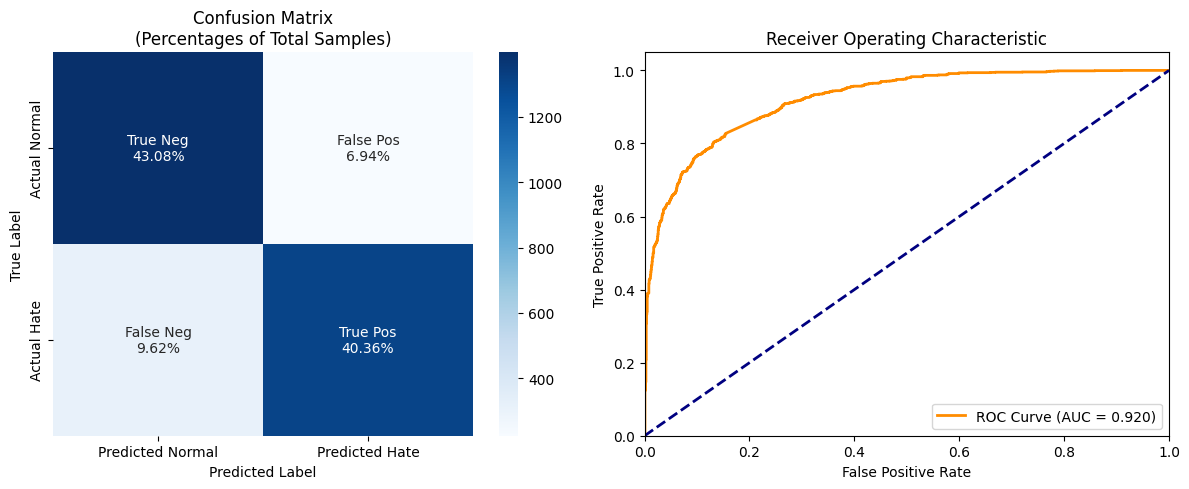

In [99]:
lgr = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1, class_weight='balanced', random_state = 42)
lgr.fit(x_train_count, y_train)
model_evaluate(lgr, x_test_count, y_test)

### Vectorize + Logistic Regression Model (Bigram)

              precision    recall  f1-score   support

           0       0.54      0.98      0.69      1622
           1       0.89      0.15      0.26      1621

    accuracy                           0.57      3243
   macro avg       0.71      0.57      0.48      3243
weighted avg       0.71      0.57      0.48      3243



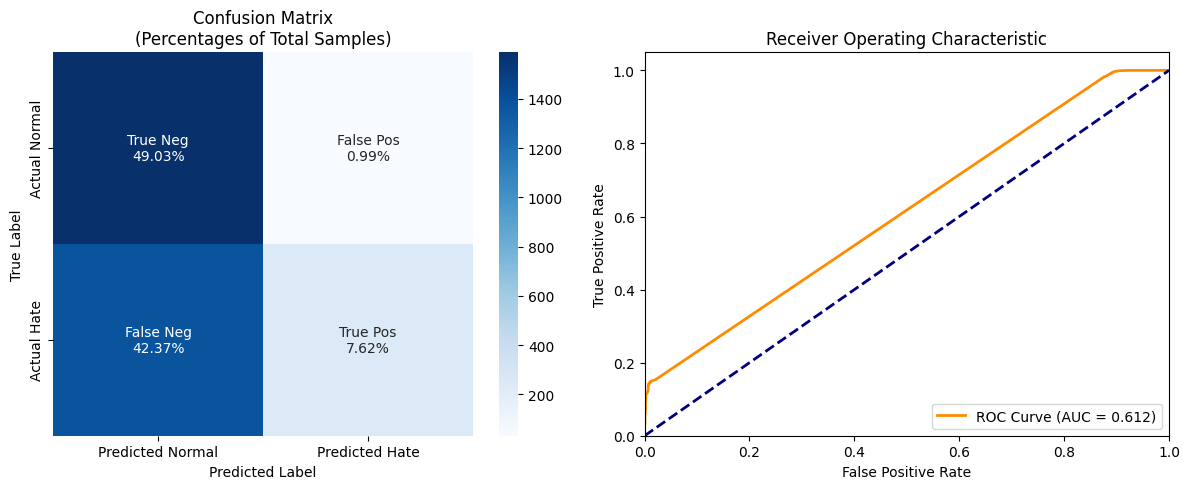

In [100]:
countvect_bi = CountVectorizer(analyzer = 'word', ngram_range = (2,2), min_df = 10, max_features = 500)
x_train_count = countvect_bi.fit_transform(X_train).toarray()
x_test_count = countvect_bi.transform(X_test).toarray()
lgr.fit(x_train_count, y_train)
model_evaluate(lgr, x_test_count, y_test)

When the model predicts hate speech, it is usually correct, but it only correctly predicts a small number of true hate speeches. This explains low recall high precision.

### Vectorize + Logistic Regression Model (Unigram + Bigram)

              precision    recall  f1-score   support

           0       0.81      0.86      0.84      1622
           1       0.85      0.80      0.83      1621

    accuracy                           0.83      3243
   macro avg       0.83      0.83      0.83      3243
weighted avg       0.83      0.83      0.83      3243



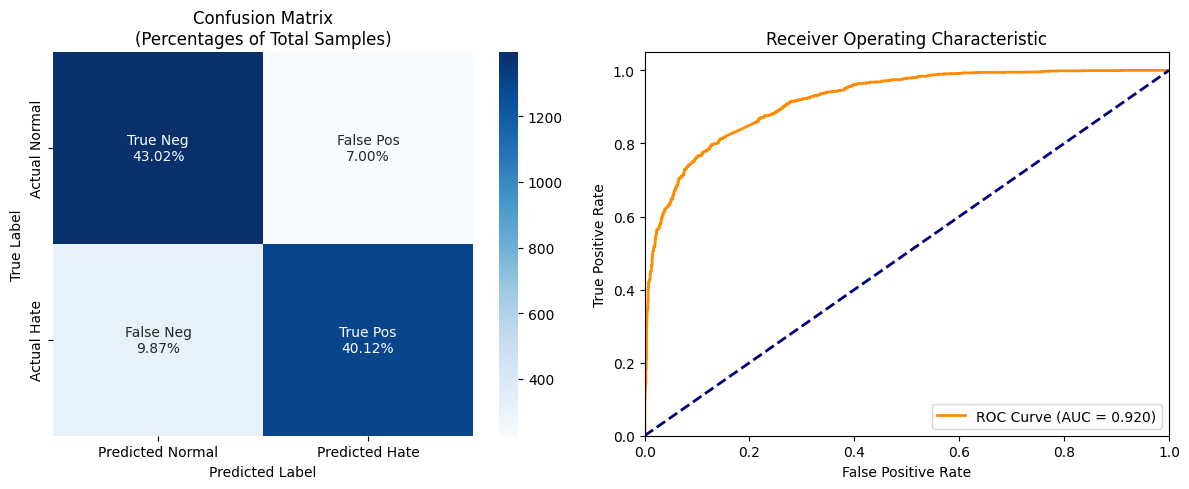

In [101]:
countvect_ub = CountVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 10, max_features = 500)
x_train_count = countvect_ub.fit_transform(X_train).toarray()
x_test_count = countvect_ub.transform(X_test).toarray()
lgr.fit(x_train_count, y_train)
model_evaluate(lgr, x_test_count, y_test)

## TF-IDF Vectorizer

### Vectorize + Logistic Regression Model (Unigrams)

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1622
           1       0.85      0.82      0.84      1621

    accuracy                           0.84      3243
   macro avg       0.84      0.84      0.84      3243
weighted avg       0.84      0.84      0.84      3243



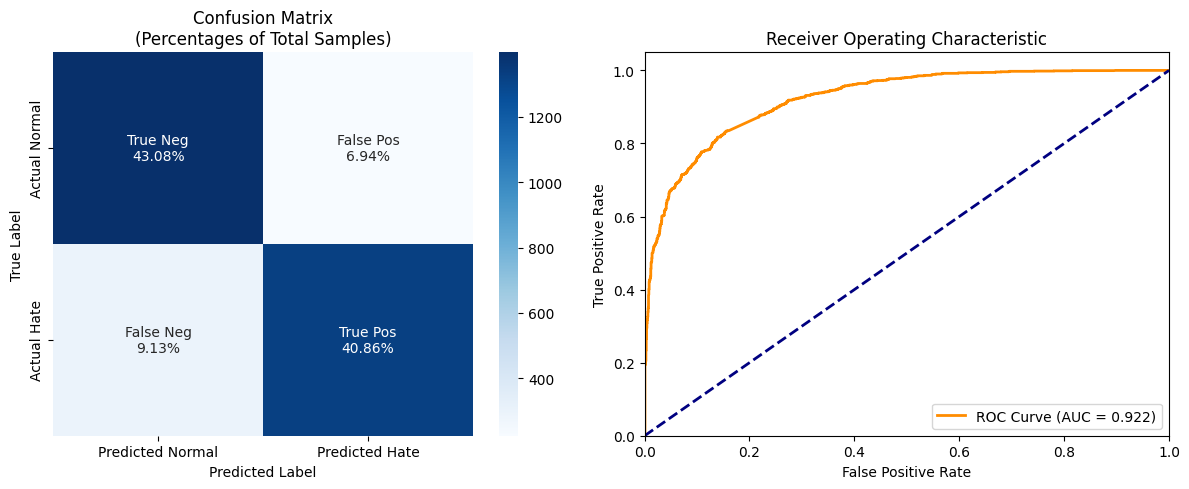

In [102]:
tfidfvect_uni = TfidfVectorizer(analyzer = 'word', ngram_range = (1,1), min_df = 10, max_features = 500)
x_train_tfidf = tfidfvect_uni.fit_transform(X_train).toarray()
x_test_tfidf = tfidfvect_uni.transform(X_test).toarray()
lgr.fit(x_train_tfidf, y_train)
model_evaluate(lgr, x_test_tfidf, y_test)

### Vectorize + Logistic Regression Model (Bigrams)

              precision    recall  f1-score   support

           0       0.54      0.98      0.69      1622
           1       0.90      0.15      0.26      1621

    accuracy                           0.57      3243
   macro avg       0.72      0.57      0.48      3243
weighted avg       0.72      0.57      0.48      3243



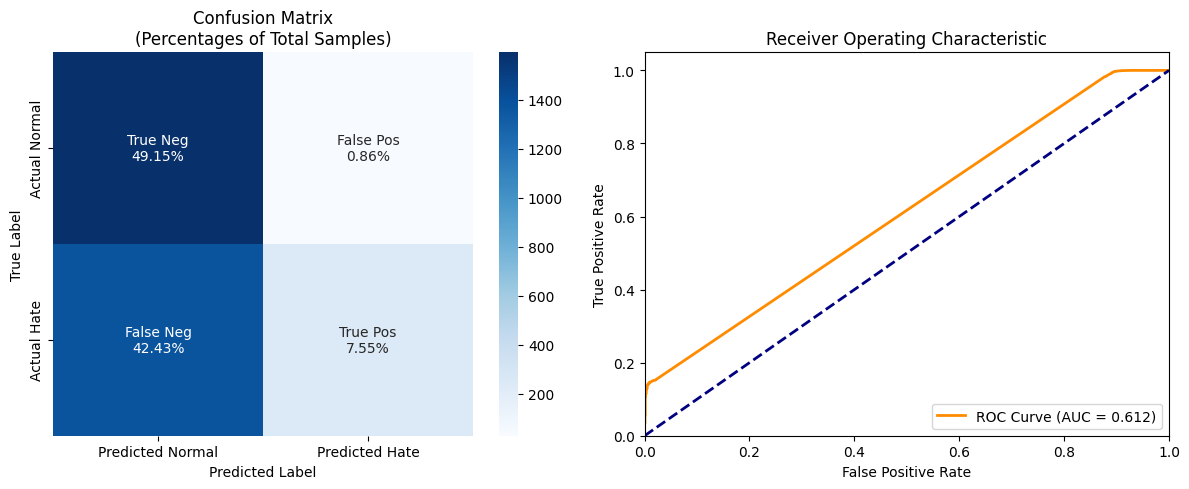

In [103]:
tfidfvect_bi = TfidfVectorizer(analyzer = 'word', ngram_range = (2,2), min_df = 10, max_features = 500)
x_train_tfidf = tfidfvect_bi.fit_transform(X_train).toarray()
x_test_tfidf = tfidfvect_bi.transform(X_test).toarray()
lgr.fit(x_train_tfidf, y_train)
model_evaluate(lgr, x_test_tfidf, y_test)

### Vectorize + Logistic Regression Model (Unigram + Bigram)

              precision    recall  f1-score   support

           0       0.82      0.86      0.84      1622
           1       0.85      0.81      0.83      1621

    accuracy                           0.84      3243
   macro avg       0.84      0.84      0.84      3243
weighted avg       0.84      0.84      0.84      3243



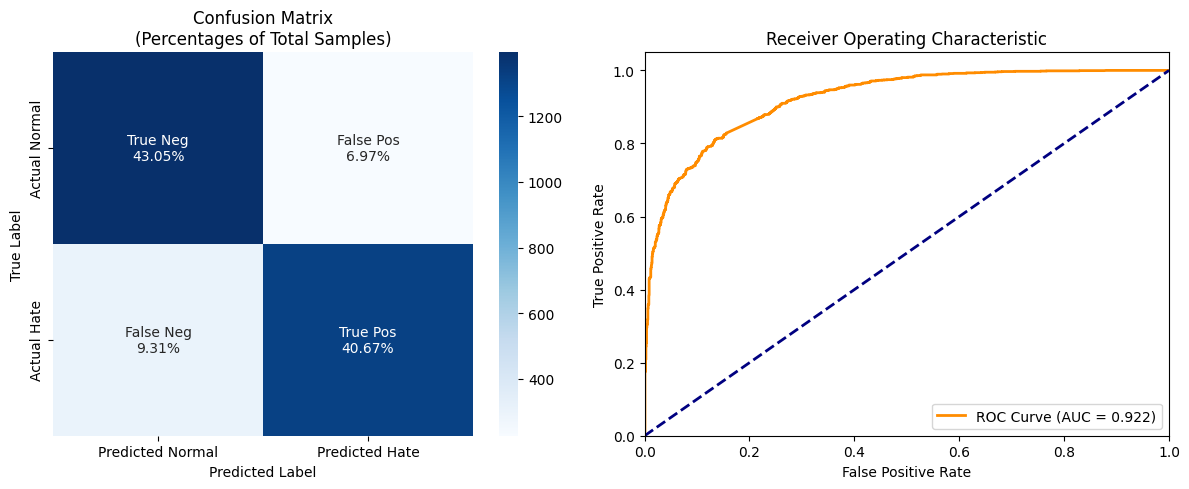

In [104]:
tfidfvect_ub = TfidfVectorizer(analyzer = 'word', ngram_range = (1,2), min_df = 10, max_features = 500)
x_train_tfidf = tfidfvect_ub.fit_transform(X_train).toarray()
x_test_tfidf = tfidfvect_ub.transform(X_test).toarray()
lgr.fit(x_train_tfidf, y_train)
model_evaluate(lgr, x_test_tfidf, y_test)

## Cross-Validation

### CountVectorizer (Unigram + Bigram)


=== CountVectorizer Cross-Validation Results ===
Precision : Mean = 0.838, Std = 0.013
Recall    : Mean = 0.782, Std = 0.017
F1        : Mean = 0.809, Std = 0.012
Roc_auc   : Mean = 0.816, Std = 0.011
Accuracy  : Mean = 0.816, Std = 0.011


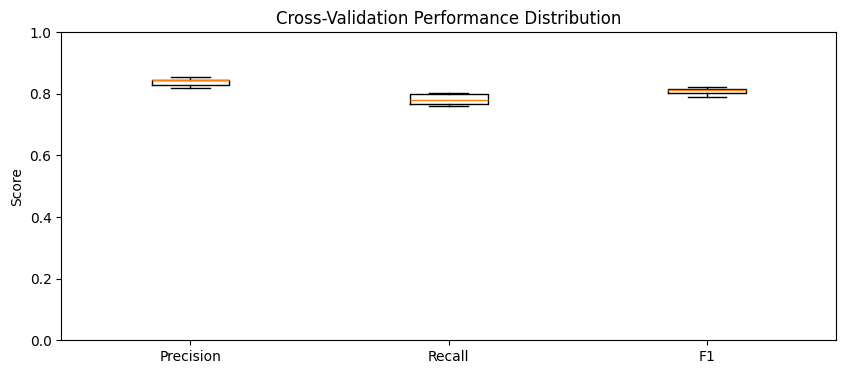

In [105]:
# Define Metrics
scoring = {
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1),
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': 'accuracy'
}

# Pipeline

pipeline = Pipeline([
    ('vect', countvect_ub),
    ('clf', lgr)
])

# Use stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run CV on raw text and labels
cv_results = cross_validate(
    estimator=pipeline,
    X=X_train,  # raw text
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Output results (mean and std)
print("\n=== CountVectorizer Cross-Validation Results ===")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")


plt.figure(figsize=(10, 4))
plt.boxplot([cv_results['test_precision'], 
             cv_results['test_recall'],
             cv_results['test_f1']],
             tick_labels=['Precision', 'Recall', 'F1'])
plt.title('Cross-Validation Performance Distribution')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

### TF-IDF Vectorizer (Unigram + Bigram)


=== TF-IDF Cross-Validation Results ===
Precision : Mean = 0.836, Std = 0.013
Recall    : Mean = 0.797, Std = 0.019
F1        : Mean = 0.816, Std = 0.015
Roc_auc   : Mean = 0.820, Std = 0.014
Accuracy  : Mean = 0.820, Std = 0.014


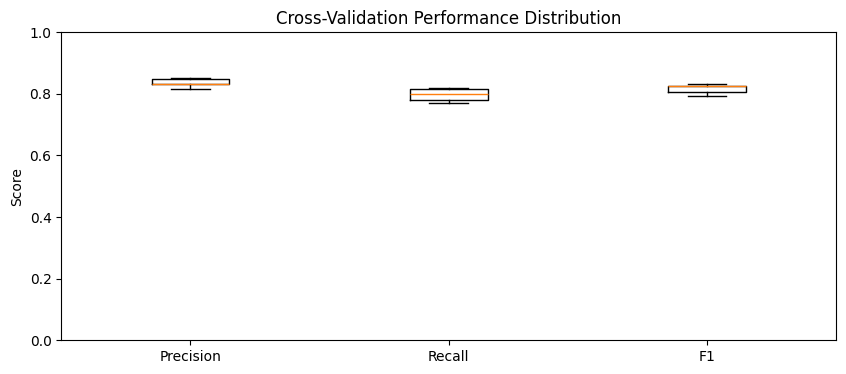

In [106]:
# Define Metrics
scoring = {
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1),
    'f1': make_scorer(f1_score, pos_label=1),
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': 'accuracy'
}

# Pipeline

pipeline = Pipeline([
    ('vect', tfidfvect_ub),
    ('clf', lgr)
])

# Use stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run CV on raw text and labels
cv_results = cross_validate(
    estimator=pipeline,
    X=X_train,  # raw text
    y=y_train,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)

# Output results (mean and std)
print("\n=== TF-IDF Cross-Validation Results ===")
for metric in scoring:
    scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize():<10}: Mean = {scores.mean():.3f}, Std = {scores.std():.3f}")


plt.figure(figsize=(10, 4))
plt.boxplot([cv_results['test_precision'], 
             cv_results['test_recall'],
             cv_results['test_f1']],
             tick_labels=['Precision', 'Recall', 'F1'])
plt.title('Cross-Validation Performance Distribution')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

# Oversampling (SMOTE)

In [107]:
X = df['cleaned_tweet']
y = df['label']

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Vectorize
tfidfvect_smote = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=10, max_df = 0.9, max_features = 5000)
X_train_vect = tfidfvect_smote.fit_transform(X_train_raw)
X_test_vect = tfidfvect_smote.transform(X_test_raw)

# Apply SMOTE on the VECTORIZED training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7909
           1       0.64      0.87      0.73      1621

    accuracy                           0.89      9530
   macro avg       0.80      0.88      0.83      9530
weighted avg       0.91      0.89      0.90      9530



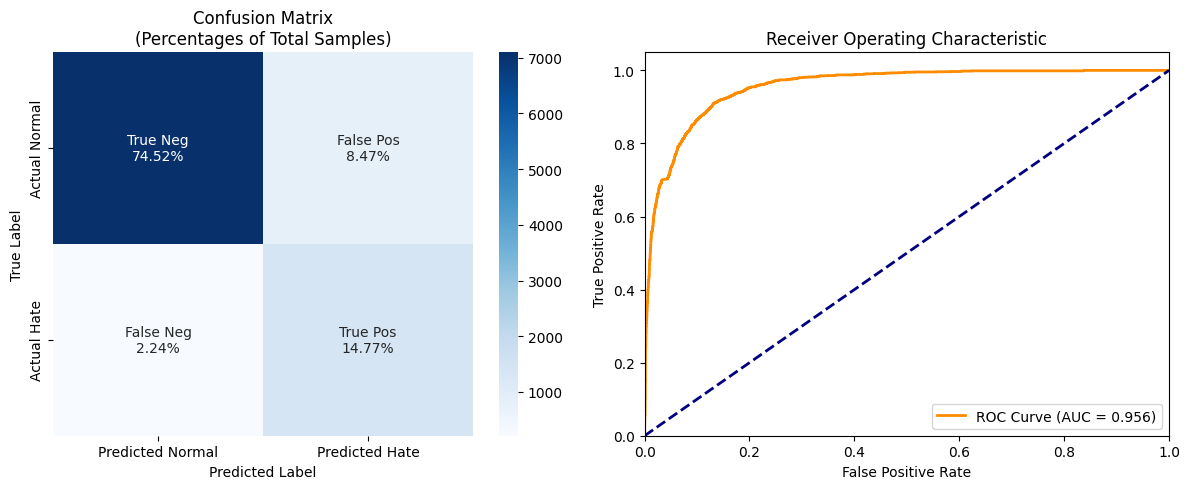

In [108]:
lgr.fit(X_train_resampled, y_train_resampled)
model_evaluate(lgr, X_test_vect, y_test)

# Oversampling (ADASYN)

In [109]:
X = df['cleaned_tweet']
y = df['label']

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

tfidfvect_adasyn = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=10, max_features = 5000)
X_train_vect = tfidfvect_adasyn.fit_transform(X_train_raw)
X_test_vect = tfidfvect_adasyn.transform(X_test_raw)

# Apply ADASYN on the VECTORIZED training data
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_vect, y_train)

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      7909
           1       0.62      0.89      0.73      1621

    accuracy                           0.89      9530
   macro avg       0.80      0.89      0.83      9530
weighted avg       0.92      0.89      0.90      9530



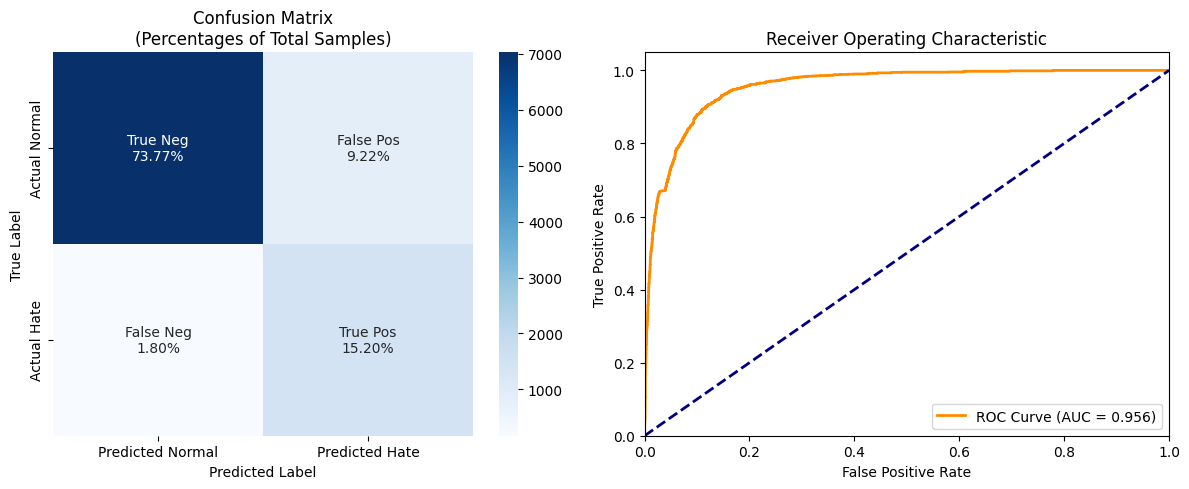

In [110]:
lgr.fit(X_train_resampled, y_train_resampled)
model_evaluate(lgr, X_test_vect, y_test)

The model (regardless if SMOTE or ADASYN) is overpredicting hate speech (low precision high recall on class 1). So we penalize errors on non-hate speech more for balance.

# Hyperparameter Tuning

In [111]:
df['label'].value_counts()

label
0    26361
1     5404
Name: count, dtype: int64

Low precision on hate speech when oversampling. But oversampling performs better in the test_tweets_anuFYb8.csv file

In [112]:
'''
# Prepare your data
X = df['cleaned_tweet']
y = df['label']
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Define pipeline using imblearn
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', ngram_range=(1, 2), min_df=10, max_df=0.9, max_features=5000)),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(random_state=42, n_jobs=-1))
])

# Parameter grid
param_dist = {
    'clf__class_weight': [
        {0: 1, 1: 1},  
        {0: 3, 1: 1},
        {0: 3.5, 1: 1},
        {0: 3.8, 1: 1},
        {0: 4, 1: 1},
        'balanced'
    ],
    'clf__solver': ['lbfgs', 'liblinear', 'saga'],
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__max_iter': [500, 1000]
}

# Scoring
scoring = {
    'f1': make_scorer(f1_score, pos_label=1),
    'precision': make_scorer(precision_score, pos_label=1),
    'recall': make_scorer(recall_score, pos_label=1)
}

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_dist,                
    scoring=scoring,
    refit='f1',
    cv=cv,
    verbose=3,                 
    n_jobs=-1,
    return_train_score=True
)

# Run it
print("Starting search...")
start_time = time.time()
grid_search.fit(X_train_raw, y_train)
print(f"\nSearch completed in {time.time() - start_time:.2f} seconds.")

# Report best results
print("\n=== Best Model ===")
print(f"Best F1-score (CV): {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")
'''

'\n# Prepare your data\nX = df[\'cleaned_tweet\']\ny = df[\'label\']\nX_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)\n\n# Define pipeline using imblearn\npipeline = Pipeline([\n    (\'tfidf\', TfidfVectorizer(analyzer=\'word\', ngram_range=(1, 2), min_df=10, max_df=0.9, max_features=5000)),\n    (\'smote\', SMOTE(random_state=42)),\n    (\'clf\', LogisticRegression(random_state=42, n_jobs=-1))\n])\n\n# Parameter grid\nparam_dist = {\n    \'clf__class_weight\': [\n        {0: 1, 1: 1},  \n        {0: 3, 1: 1},\n        {0: 3.5, 1: 1},\n        {0: 3.8, 1: 1},\n        {0: 4, 1: 1},\n        \'balanced\'\n    ],\n    \'clf__solver\': [\'lbfgs\', \'liblinear\', \'saga\'],\n    \'clf__C\': [0.01, 0.1, 1, 10],\n    \'clf__max_iter\': [500, 1000]\n}\n\n# Scoring\nscoring = {\n    \'f1\': make_scorer(f1_score, pos_label=1),\n    \'precision\': make_scorer(precision_score, pos_label=1),\n    \'recall\': make_scorer(recall_score, po

# Apply Best Parameters

              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7909
           1       0.75      0.73      0.74      1621

    accuracy                           0.91      9530
   macro avg       0.85      0.84      0.84      9530
weighted avg       0.91      0.91      0.91      9530



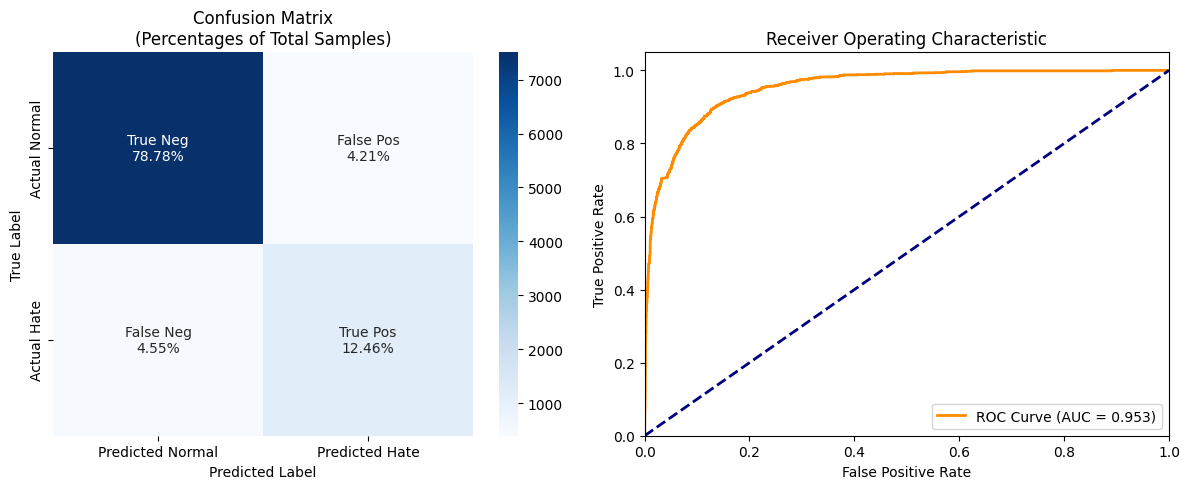

In [113]:
lgr = LogisticRegression(solver = 'lbfgs', max_iter = 500, class_weight= {0: 3, 1: 1}, C = 1, n_jobs=-1, random_state = 42)

X = df['cleaned_tweet']
y = df['label']

# Split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

tfidfvect_smote = TfidfVectorizer(analyzer='word', ngram_range=(1,2), min_df=10, max_df = 0.9, max_features = 5000)
X_train_vect = tfidfvect_smote.fit_transform(X_train_raw)
X_test_vect = tfidfvect_smote.transform(X_test_raw)

# Apply SMOTE on the VECTORIZED training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

lgr.fit(X_train_resampled, y_train_resampled)
model_evaluate(lgr, X_test_vect, y_test)

# False Positives / False Negatives Analysis

In [114]:
X_new_vect = tfidfvect_smote.transform(X)
predictions = lgr.predict(X_new_vect)

In [115]:
check_df = df.copy()
check_df['predictions'] = predictions

In [116]:
false_positives = check_df[(check_df['label'] == 0) & (check_df['predictions'] == 1)]
false_positives.head()

,label,cleaned_tweet,predictions
2,0,complet random not believ countri two presidenti nomine racist bigot hypocrit witch,1
15,0,day jump pig note jumpingforjoy pig,1
77,0,done pick met notevenbeatthebrav stayingr,1
95,0,sipisopiso waterfal,1
116,0,nigth rumba nigthlif,1


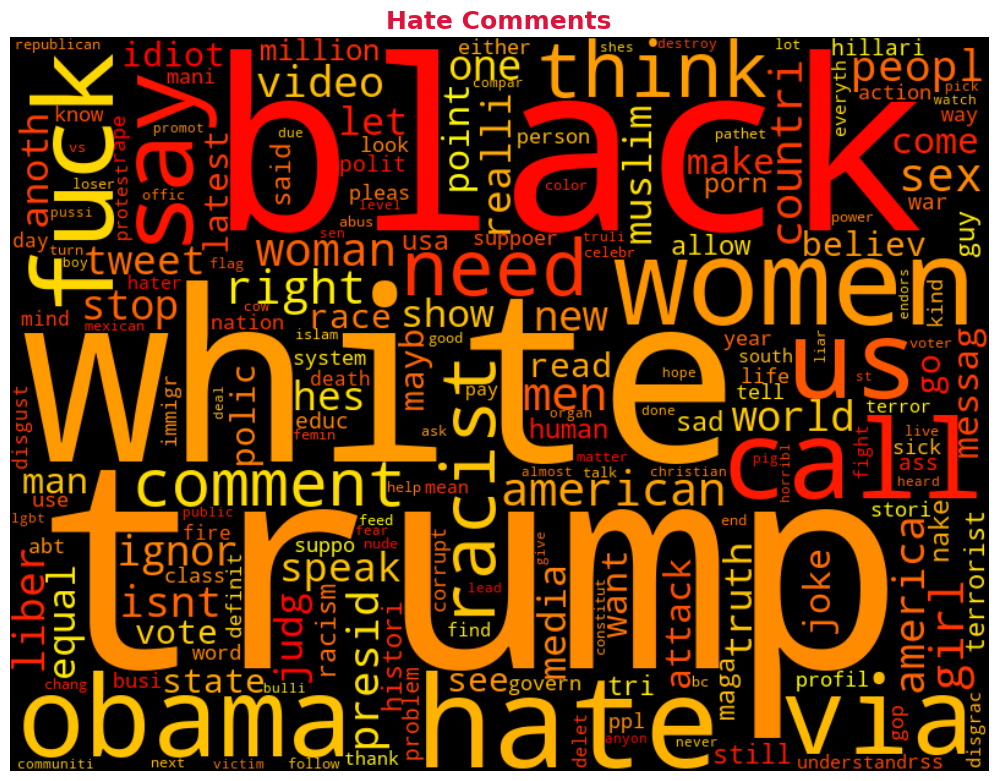

In [117]:
# Prepare text
text = " ".join(false_positives['cleaned_tweet'][false_positives.label == 0])

# Generate word clouds with improvements

train_cloud = WordCloud(
    width=800, height=600,
    collocations=False,
    background_color='black',
    colormap='autumn',
    max_words=200,
    random_state=42
).generate(text)

# Create side-by-side plots
fig, axs = plt.subplots(1, 1, figsize=(18, 9))
axs.imshow(train_cloud, interpolation='bilinear')
axs.axis('off')
axs.set_title('Hate Comments', fontsize=18, weight='bold', color='crimson')

plt.tight_layout(pad=5)
plt.show()

In [118]:
false_negatives = check_df[(check_df['label'] == 1) & (check_df['predictions'] == 0)]
false_negatives.head()

,label,cleaned_tweet,predictions
0,1,bout play game lol,0
28,1,hope guy would not say come trump get speak mind peopl enough pc alreadi sarcasm,0
52,1,appar not thing not hate asian pare not instil massiv amount,0
83,1,facemask run risk look unintent moredun edinburgh,0
93,1,end smoke reefer go crazi listen negro music eat mr ansling cannabi swingtanzenverboten,0


# Save Model

In [119]:
# This is the best model so far
with open(r'models\logistic_model.pkl', 'wb') as f:
    pickle.dump(lgr, f)

with open(r'models\tfidf_vectorizer_logistic.pkl', 'wb') as f:
    pickle.dump(tfidfvect_smote, f)